# Needed packages

In [10]:
import pickle
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from AptivDataExtractors.utilities.MathFunctions import calc_velocity_in_position, calc_position_in_bounding_box, pol2cart, rot_2d_sae_cs
from radardetseval.configs.default_radar import DefaultRadar
from radardetseval.visualization.plot_polyline import plot_polyline, plot_polyline_range_rates
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_point import plot_point
from radardetseval.visualization.plot_object import plot_object_wrapper
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.ecdf import ecdf

from radardetseval.stats.nees import nees_value
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_object import plot_object
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.cart_state_to_polar_state import cart_state_to_polar_state

# Load data

In [11]:
data_path = r'private\sim_ref_point_x0_01_y0_01_n200000.pickle'
with open(data_path, 'rb') as handle:
    data = pickle.load(handle)
    
gt_object = data['gt_object']
ref_point = data['ref_point']
sim_out = data['sim_out']

# Ground truth data summary

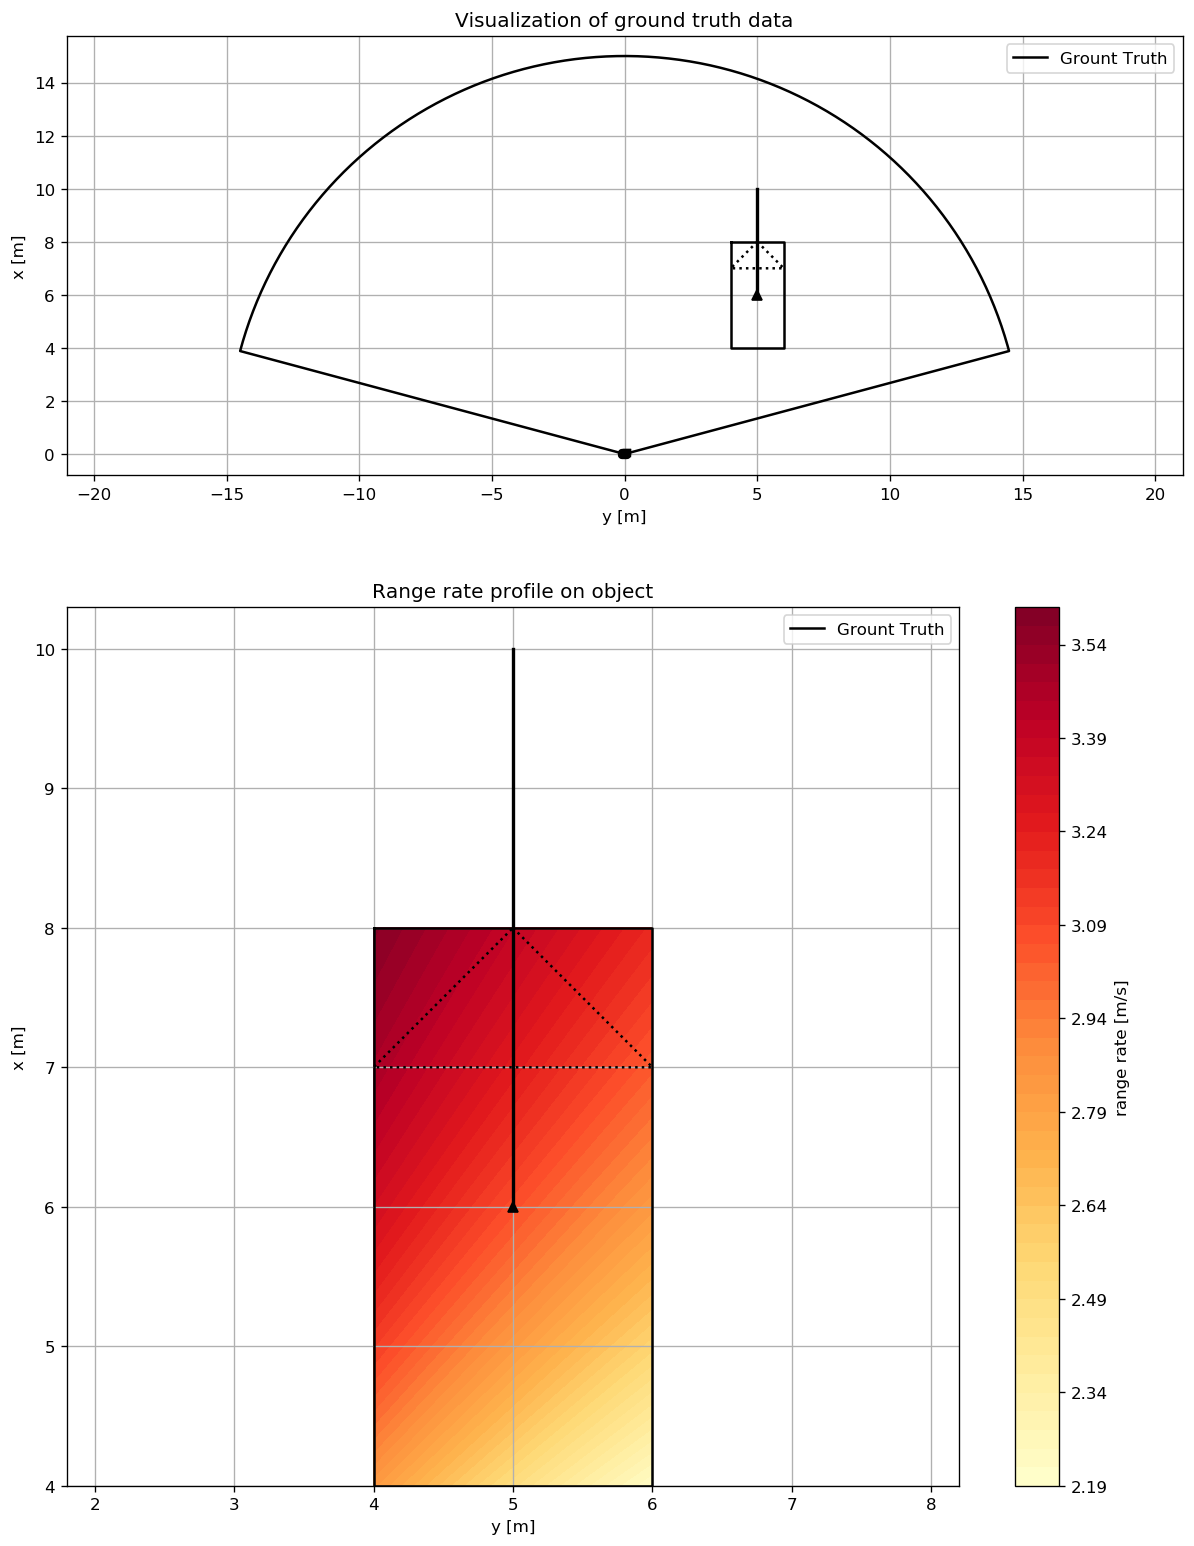

In [12]:
def plot_detection_wrapper(ax, det, **kwargs):
    plot_detection_scs(ax, det.det_range, det.det_range_rate, det.det_azimuth, **kwargs)
    
def get_range_rate_profile(rt_object, n_grid=101):
    x_ref_mesh, y_ref_mesh = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))
    pos_x, pos_y = calc_position_in_bounding_box(rt_object.position_x, rt_object.position_y,
                                                 rt_object.bounding_box_dimensions_x,
                                                 rt_object.bounding_box_dimensions_y,
                                                 rt_object.bounding_box_orientation,
                                                 rt_object.bounding_box_refpoint_long_offset_ratio,
                                                 rt_object.bounding_box_refpoint_lat_offset_ratio,
                                                 x_ref_mesh, y_ref_mesh)
    vel_x, vel_y = calc_velocity_in_position(rt_object.position_x, rt_object.position_y,
                                             rt_object.velocity_otg_x, rt_object.velocity_otg_y,
                                             rt_object.yaw_rate,
                                             pos_x, pos_y)
    _, _, range_rate, _ = cart_state_to_polar_state(pos_x, pos_y, vel_x, vel_y)
    return pos_x, pos_y, range_rate

fig1=plt.figure(figsize=(12, 16), dpi= 120, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])
plot_sensor(ax0, azimuth=np.deg2rad(75.0), max_range=15.0)
plot_object_wrapper(ax0, gt_object, color='k', label='Grount Truth')
ax0.set_title('Visualization of ground truth data')
ax0.set_xlabel('y [m]')
ax0.set_ylabel('x [m]')
ax0.axis('equal')
ax0.grid()
publish_reduced_labels(ax0)

ax1 = plt.subplot(gs[1])
plot_object_wrapper(ax1, gt_object, color='k', label='Grount Truth')
pos_x, pos_y, range_rate = get_range_rate_profile(gt_object)
cont = ax1.contourf(pos_y, pos_x, range_rate, 50, cmap='YlOrRd')
ax1.axis('equal')
ax1.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
ax1.set_title('Range rate profile on object')
ax1.grid()
cbar = fig1.colorbar(cont, ax=ax1)
cbar.ax.set_ylabel('range rate [m/s]')
publish_reduced_labels(ax1)

# Data examples

In [13]:
valid_df = sim_out.iloc[0:5]
valid_df

,ref_point_x,ref_point_y,nees_value,opt_success,opt_nit,ref_position_x,ref_position_y,ref_velocity_otg_x,ref_velocity_otg_y,deviation_range,deviation_azimuth,deviation_range_rate,gt_ref_point_x,gt_ref_point_y
0,0.025844,0.000000,4.303790,True,6,4.052188,4.182151,3.980248,-0.003851,3.666629e-01,0.012366,-0.099900,0.01,0.01
1,0.028827,0.000000,7.500964,True,4,4.053548,4.098024,4.010213,-0.007275,4.981595e-01,0.017763,-0.125898,0.01,0.01
2,0.002832,0.072748,0.786782,True,5,4.040404,4.045653,4.029205,-0.006406,-5.902882e-08,0.001096,0.053086,0.01,0.01
3,0.043930,0.078228,0.203289,True,5,4.171050,4.159410,4.010981,-0.029487,-7.168927e-08,0.000557,0.026985,0.01,0.01
4,0.074173,0.200533,2.463801,True,5,4.273223,4.244947,3.998044,0.000104,-6.872695e-08,0.001915,0.094010,0.01,0.01


# Analysis of reference point distribution

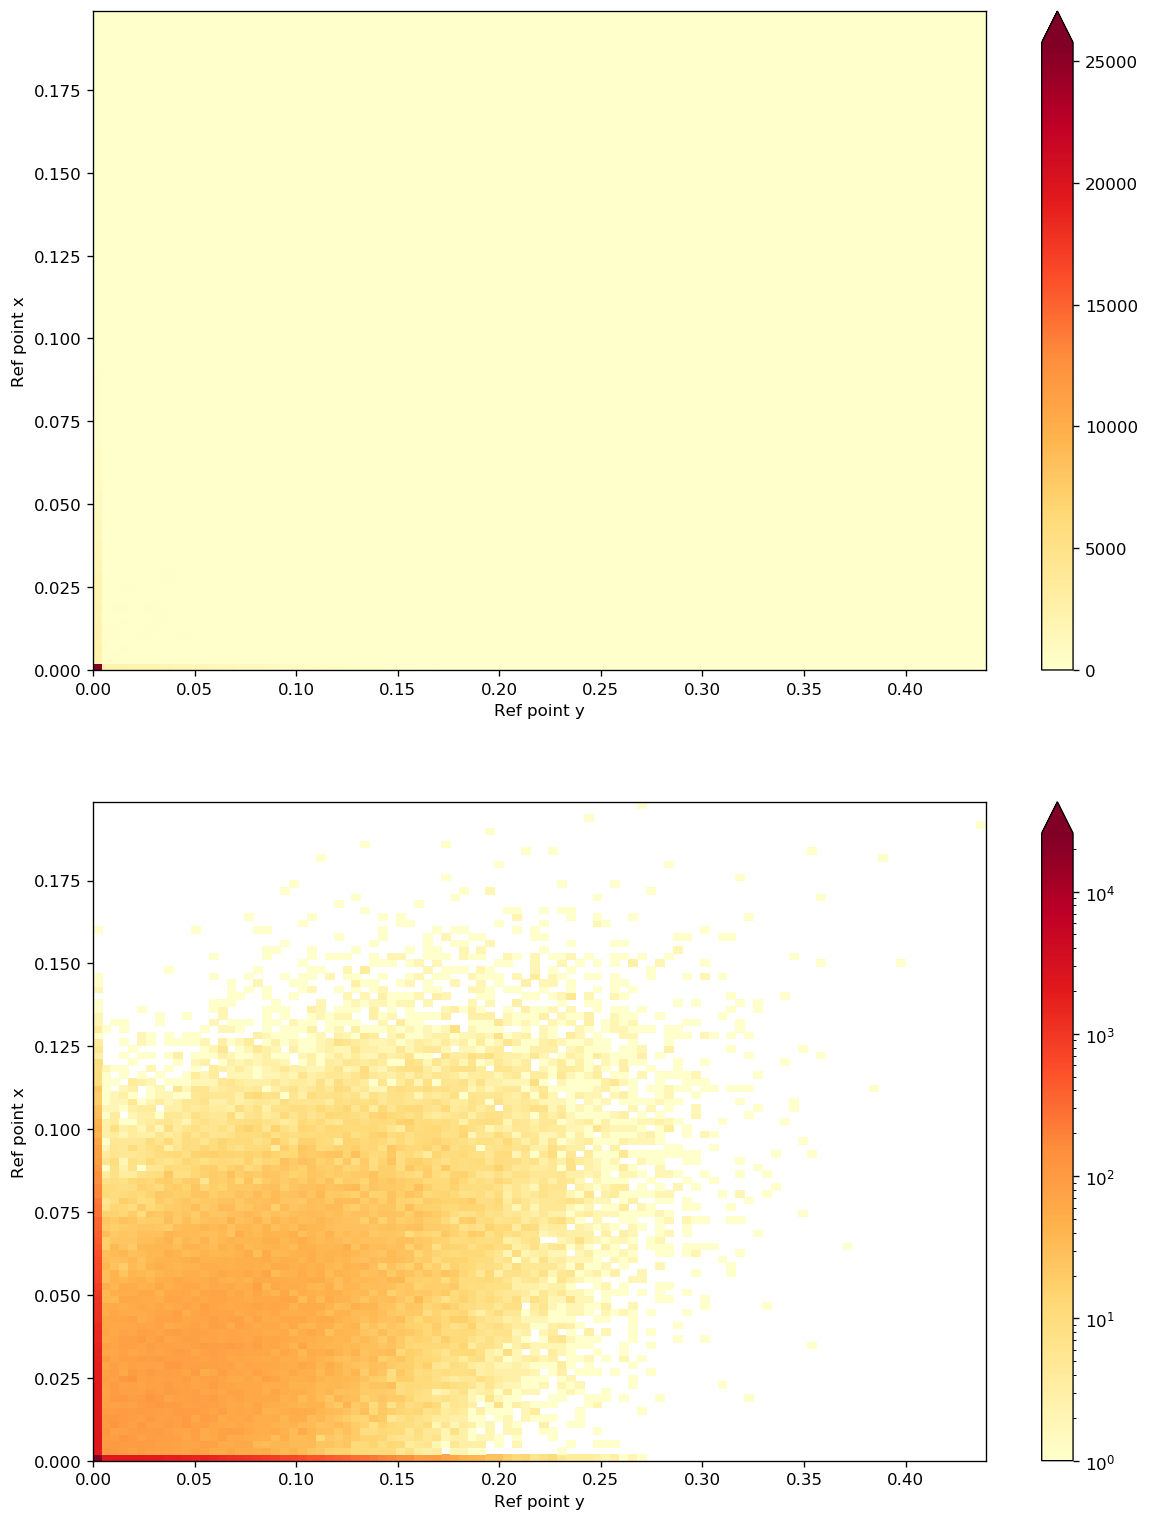

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16), dpi= 120, facecolor='w', edgecolor='k')

hist_out  = ax[0].hist2d(sim_out.ref_point_y, sim_out.ref_point_x, bins=100,
                   cmap='YlOrRd')
ax[0].set_xlabel('Ref point y')
ax[0].set_ylabel('Ref point x')
fig.colorbar(hist_out[3], ax=ax[0], extend='max')

hist_out = ax[1].hist2d(sim_out.ref_point_y, sim_out.ref_point_x, bins=100,
                   norm=mcolors.LogNorm(),
                   cmap='YlOrRd')
ax[1].set_xlabel('Ref point y')
ax[1].set_ylabel('Ref point x')
fig.colorbar(hist_out[3], ax=ax[1], extend='max')

# NEES distributions analysis

c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


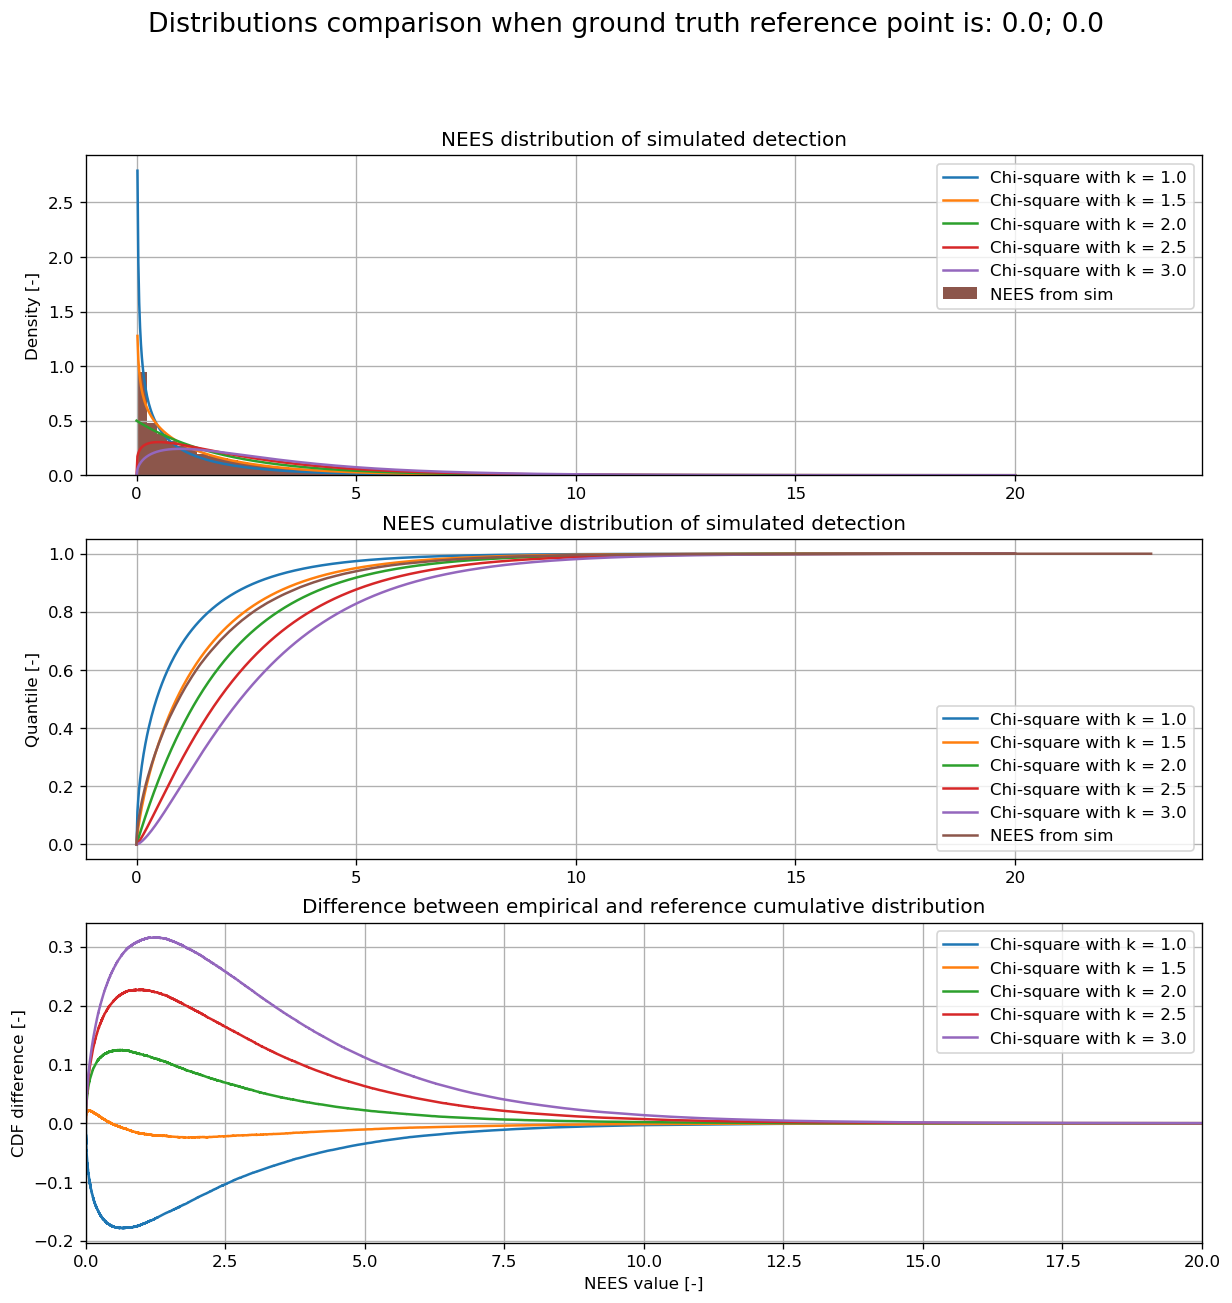

In [15]:
def visualize_distributions(df, chi2_dof=[1.0, 1.5, 2.0, 2.5, 3.0]):
    x_ref = np.linspace(0, 20, 1000)
    n_bins = 100

    plt.subplot(3, 1, 1)
    for dof in chi2_dof:
        y_ref = chi2.pdf(x_ref, dof)
        plt.plot(x_ref, y_ref, label=f'Chi-square with k = {dof:.1f}')
    df['nees_value'].hist(bins=n_bins, density=True, label='NEES from sim')
    plt.ylabel('Density [-]')
    plt.title('NEES distribution of simulated detection')
    plt.legend()

    plt.subplot(3, 1, 2)
    x_ecdf, y_ecdf = ecdf(df['nees_value'])

    for dof in chi2_dof:
        y_ref_cdf = chi2.cdf(x_ref, dof)
        plt.plot(x_ref, y_ref_cdf, label=f'Chi-square with k = {dof:.1f}')
    plt.plot(x_ecdf, y_ecdf, label='NEES from sim')
    plt.ylabel('Quantile [-]')
    plt.title('NEES cumulative distribution of simulated detection')
    plt.grid()
    plt.legend()
    
    plt.subplot(3, 1, 3)
    for dof in chi2_dof:
        y_ref_ecdf = chi2.cdf(x_ecdf, dof)
        ecdf_diff = y_ecdf - y_ref_ecdf
        plt.plot(x_ecdf, ecdf_diff, label=f'Chi-square with k = {dof:.1f}')
    plt.xlabel('NEES value [-]')
    plt.ylabel('CDF difference [-]')
    plt.grid()
    plt.legend()
    plt.xlim([0, 20])
    plt.title('Difference between empirical and reference cumulative distribution')

fig3=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig3.suptitle(f'Distributions comparison when ground truth reference point is: {ref_point[0]:.1f}; {ref_point[1]:.1f}', fontsize=16)
visualize_distributions(sim_out)

## Split into 3 data sets

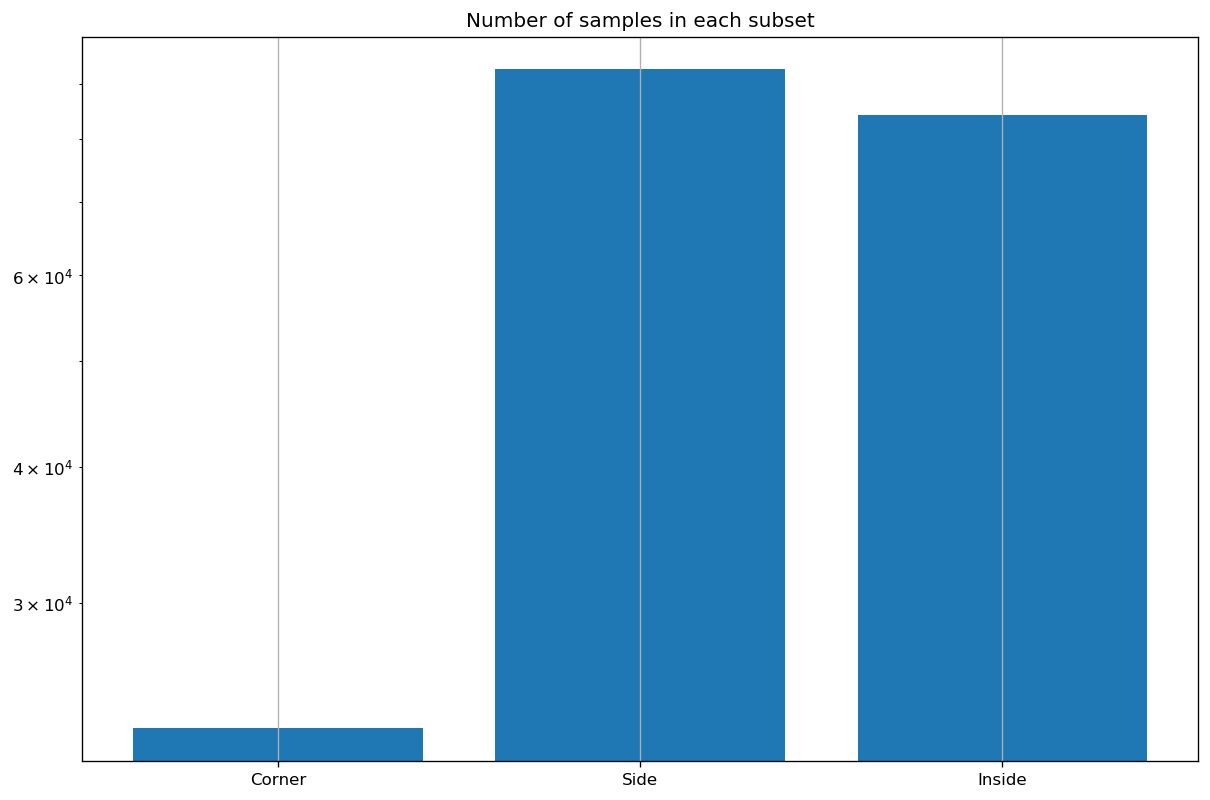

In [16]:
ref_point_x_on_side = np.logical_or(sim_out.ref_point_x < 0.001, sim_out.ref_point_x > 0.999)
ref_point_y_on_side = np.logical_or(sim_out.ref_point_y < 0.001, sim_out.ref_point_y > 0.999)
sim_out_corner = sim_out[np.logical_and(ref_point_x_on_side, ref_point_y_on_side)]
sim_out_side = sim_out[np.logical_xor(ref_point_x_on_side, ref_point_y_on_side)]
sim_out_inside = sim_out[np.logical_and(np.logical_not(ref_point_x_on_side), np.logical_not(ref_point_y_on_side))]

fig3=plt.figure(figsize=(12, 8), dpi= 120, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
data_len = [len(sim_out_corner), len(sim_out_side), len(sim_out_inside)]
data_labels = ['Corner', 'Side', 'Inside']
x_values = np.arange(len(data_len)) 
ax.bar(x_values, data_len)
ax.set_title(f'Number of samples in each subset')
ax.set_yscale('log')
ax.set_xticks(x_values)
ax.set_xticklabels(data_labels)
ax.grid()


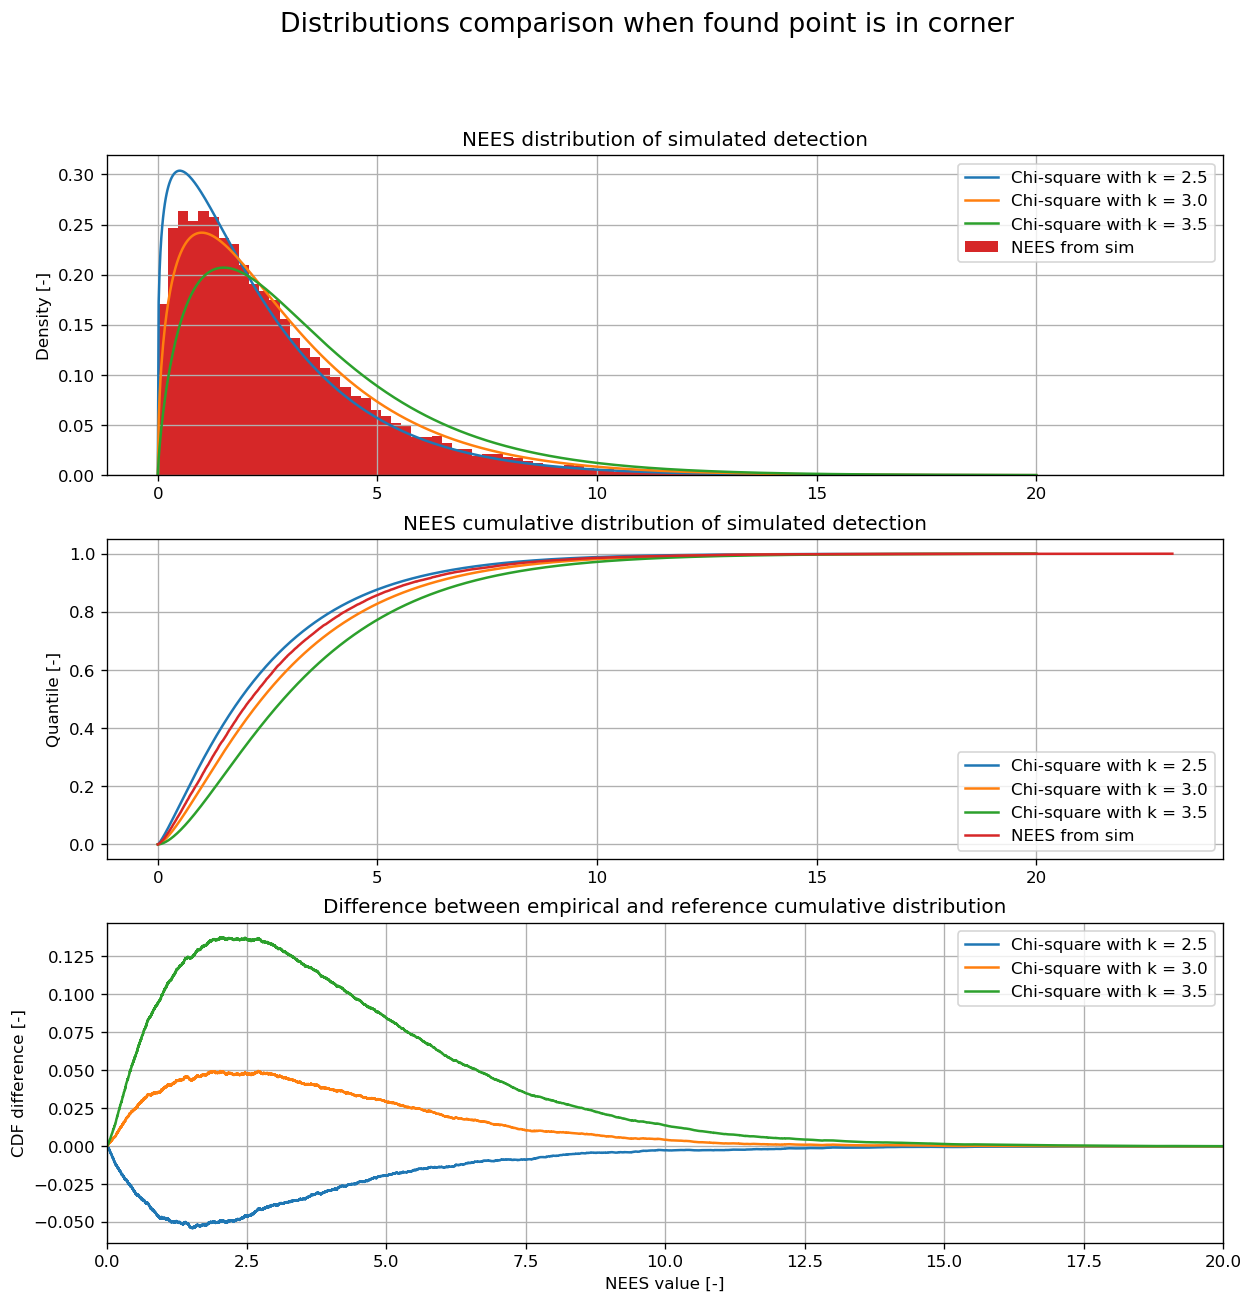

In [17]:
fig3=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig3.suptitle('Distributions comparison when found point is in corner', fontsize=16)
visualize_distributions(sim_out_corner, [2.5, 3.0, 3.5])

c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


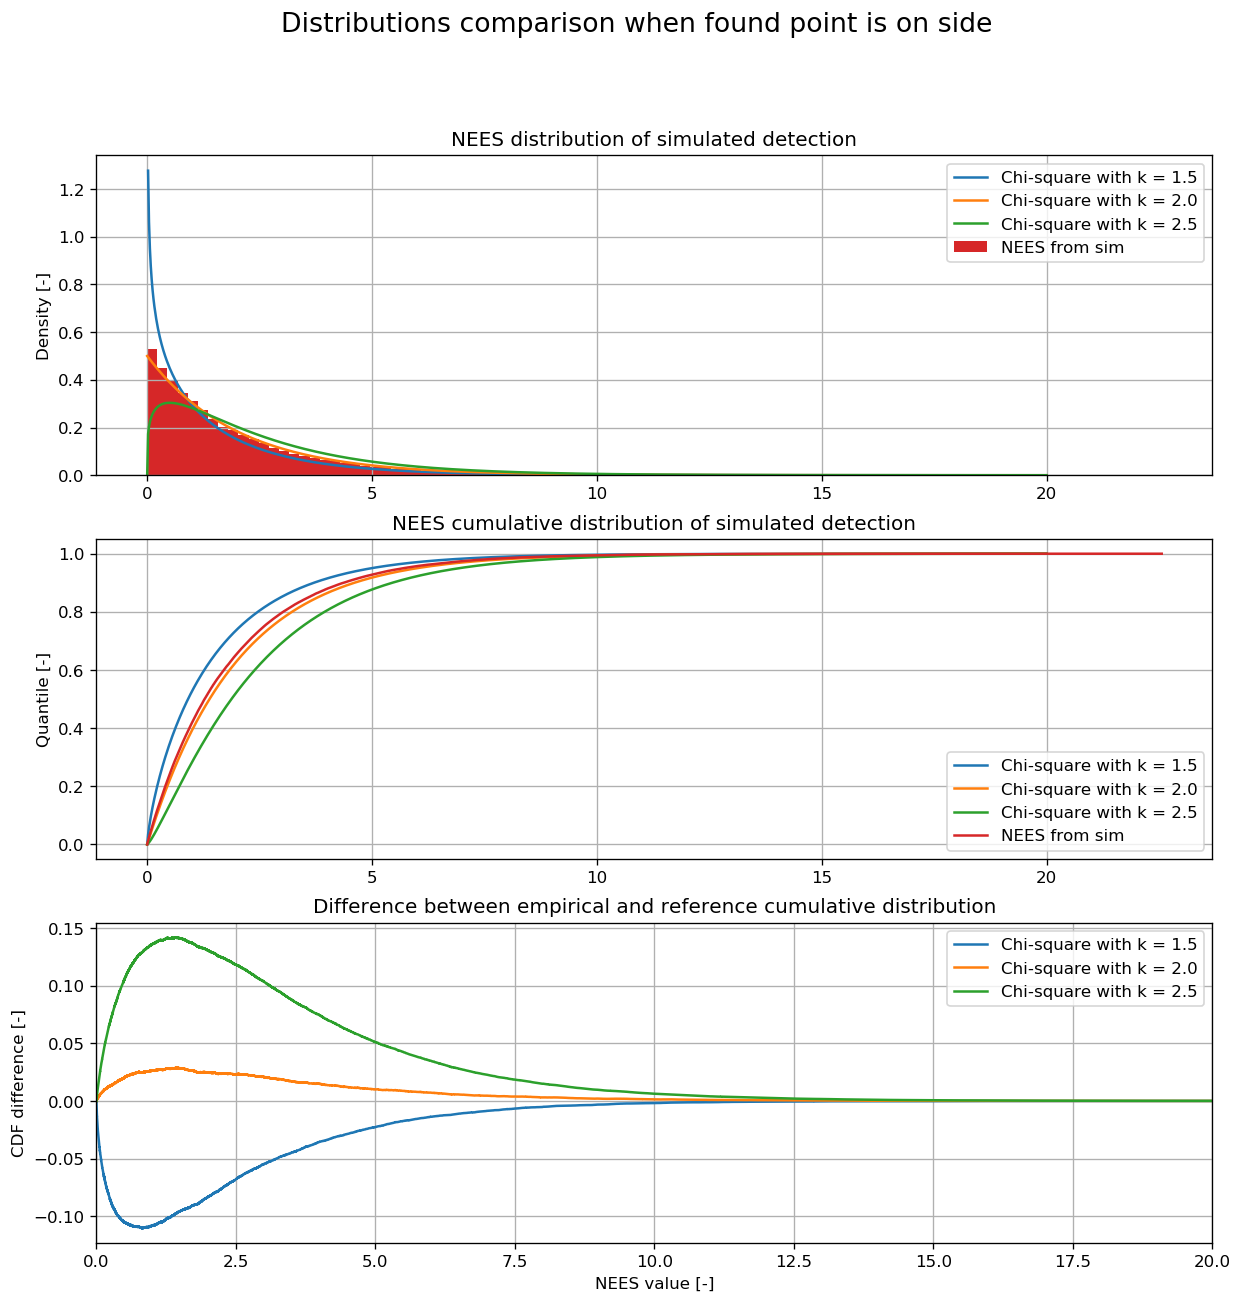

In [18]:
fig3=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig3.suptitle('Distributions comparison when found point is on side', fontsize=16)
visualize_distributions(sim_out_side, [1.5, 2.0, 2.5])

c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


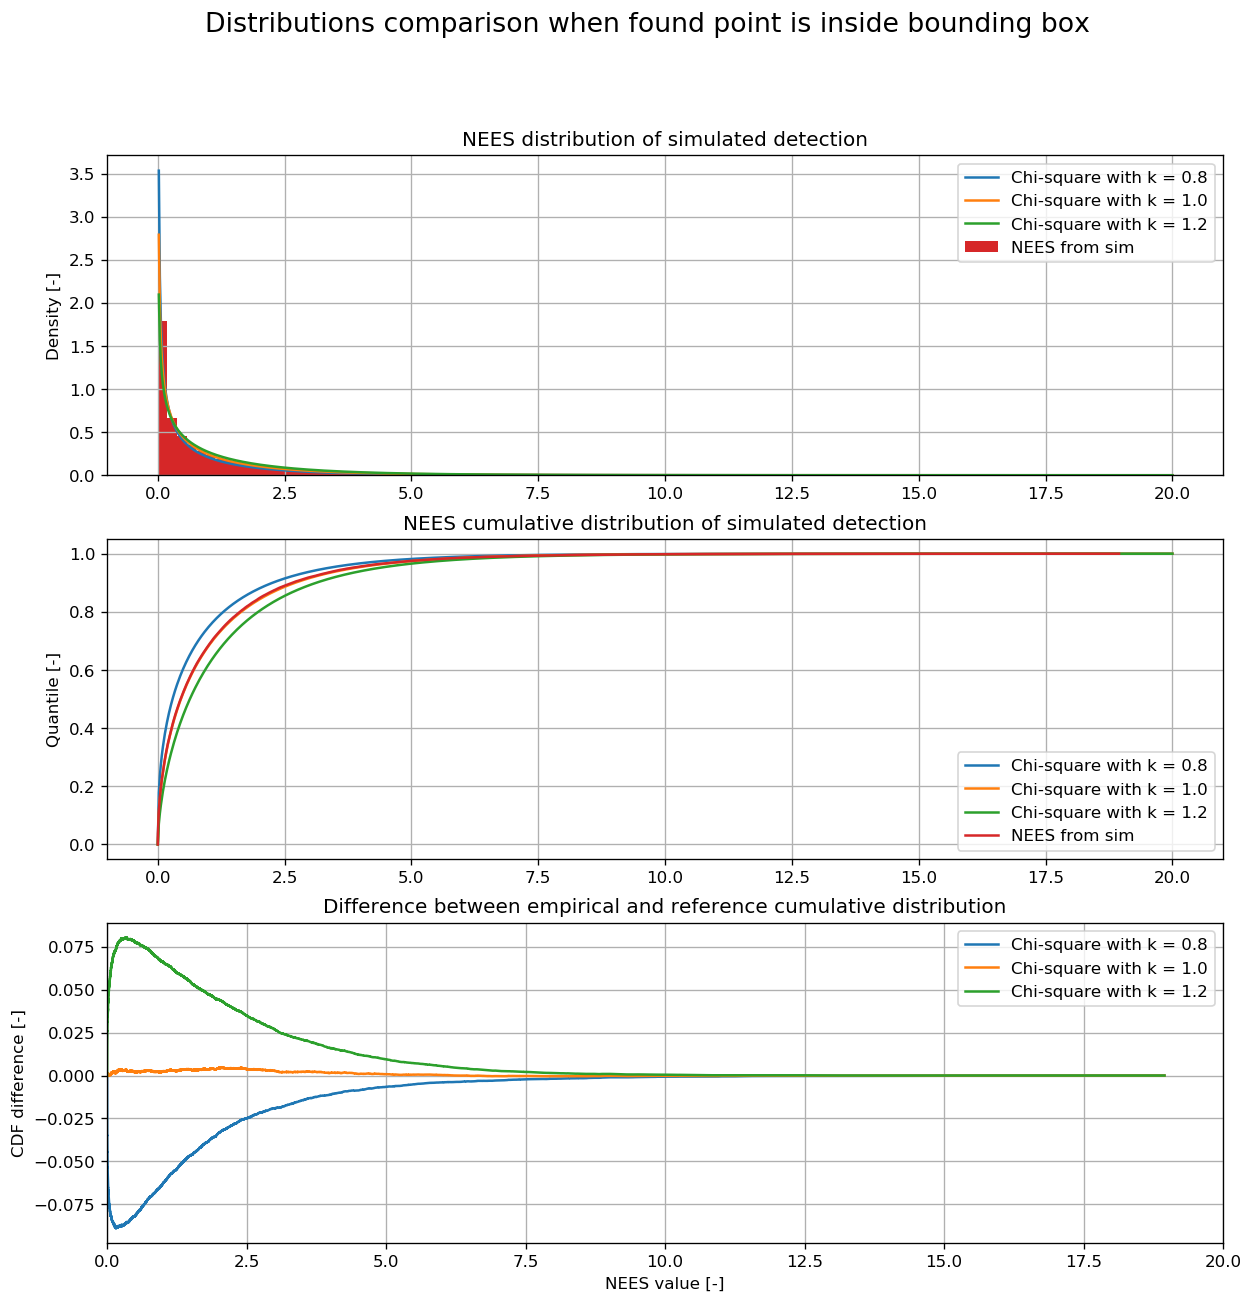

In [19]:
fig3=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig3.suptitle('Distributions comparison when found point is inside bounding box', fontsize=16)
visualize_distributions(sim_out_inside,[0.8, 1.0, 1.2])

# Distributions of detections physical atributes

In [20]:
def plot_single_det_distribution(deviation, gt_std, sigma_level, xlabel):
    n_ref_samples = 1000
    ref_x = np.linspace(-sigma_level*gt_std, sigma_level*gt_std, n_ref_samples)
    ref_pdf = norm.pdf(ref_x, scale=gt_std)
    plt.hist(deviation, bins='auto', density=True, label='Deviation based on associated point')
    plt.plot(ref_x, ref_pdf, label= "Grount Truth")  
    plt.xlabel(xlabel)
    plt.ylabel('Density [-]')
    plt.legend()
    plt.grid()

def plot_det_distributions(df, gt_radar_unc, sigma_level=4.0):    
    
    plt.subplot(3, 1, 1)
    plot_single_det_distribution(df['deviation_range'], gt_radar_unc.range_std, sigma_level, 'Range Deviation [m]')   

    plt.subplot(3, 1, 2)
    plot_single_det_distribution(np.rad2deg(df['deviation_azimuth']), 
                                 np.rad2deg(gt_radar_unc.azimuth_std), sigma_level, 'Azimuth Deviation [deg]')  
    
    plt.subplot(3, 1, 3)
    plot_single_det_distribution(df['deviation_range_rate'], gt_radar_unc.range_rate_std, sigma_level, 'Range Rate Deviation [m/s]')  
    

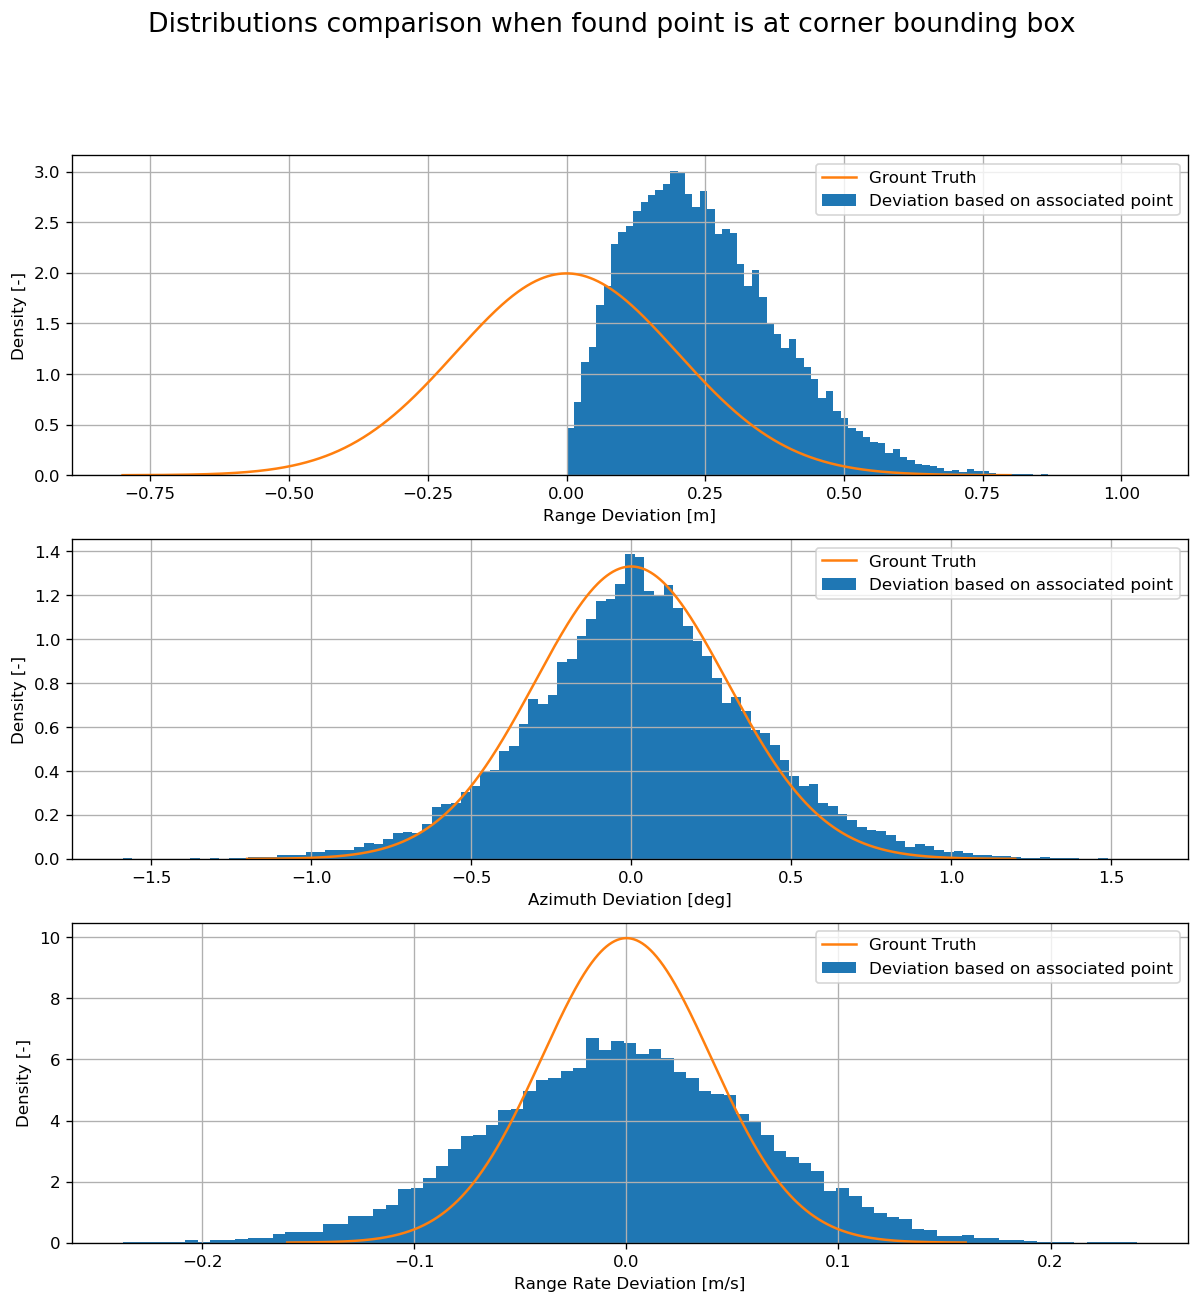

In [21]:
fig=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig.suptitle('Distributions comparison when found point is at corner bounding box', fontsize=16)
plot_det_distributions(sim_out_corner, DefaultRadar)

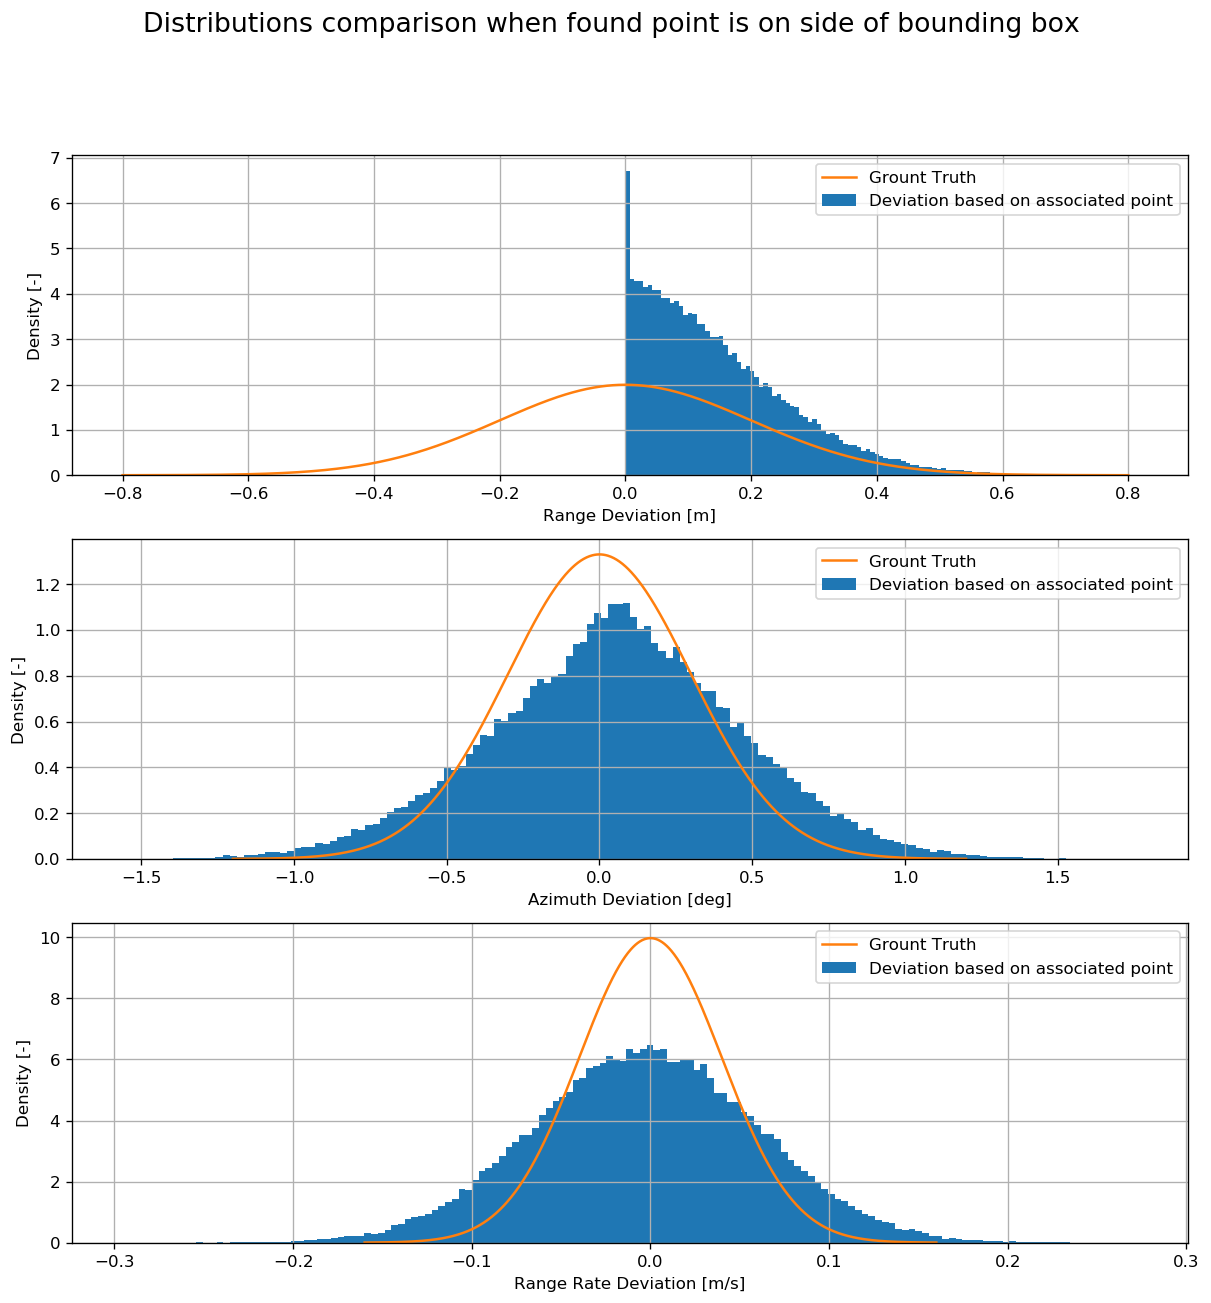

In [22]:
fig=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig.suptitle('Distributions comparison when found point is on side of bounding box', fontsize=16)
plot_det_distributions(sim_out_side, DefaultRadar)

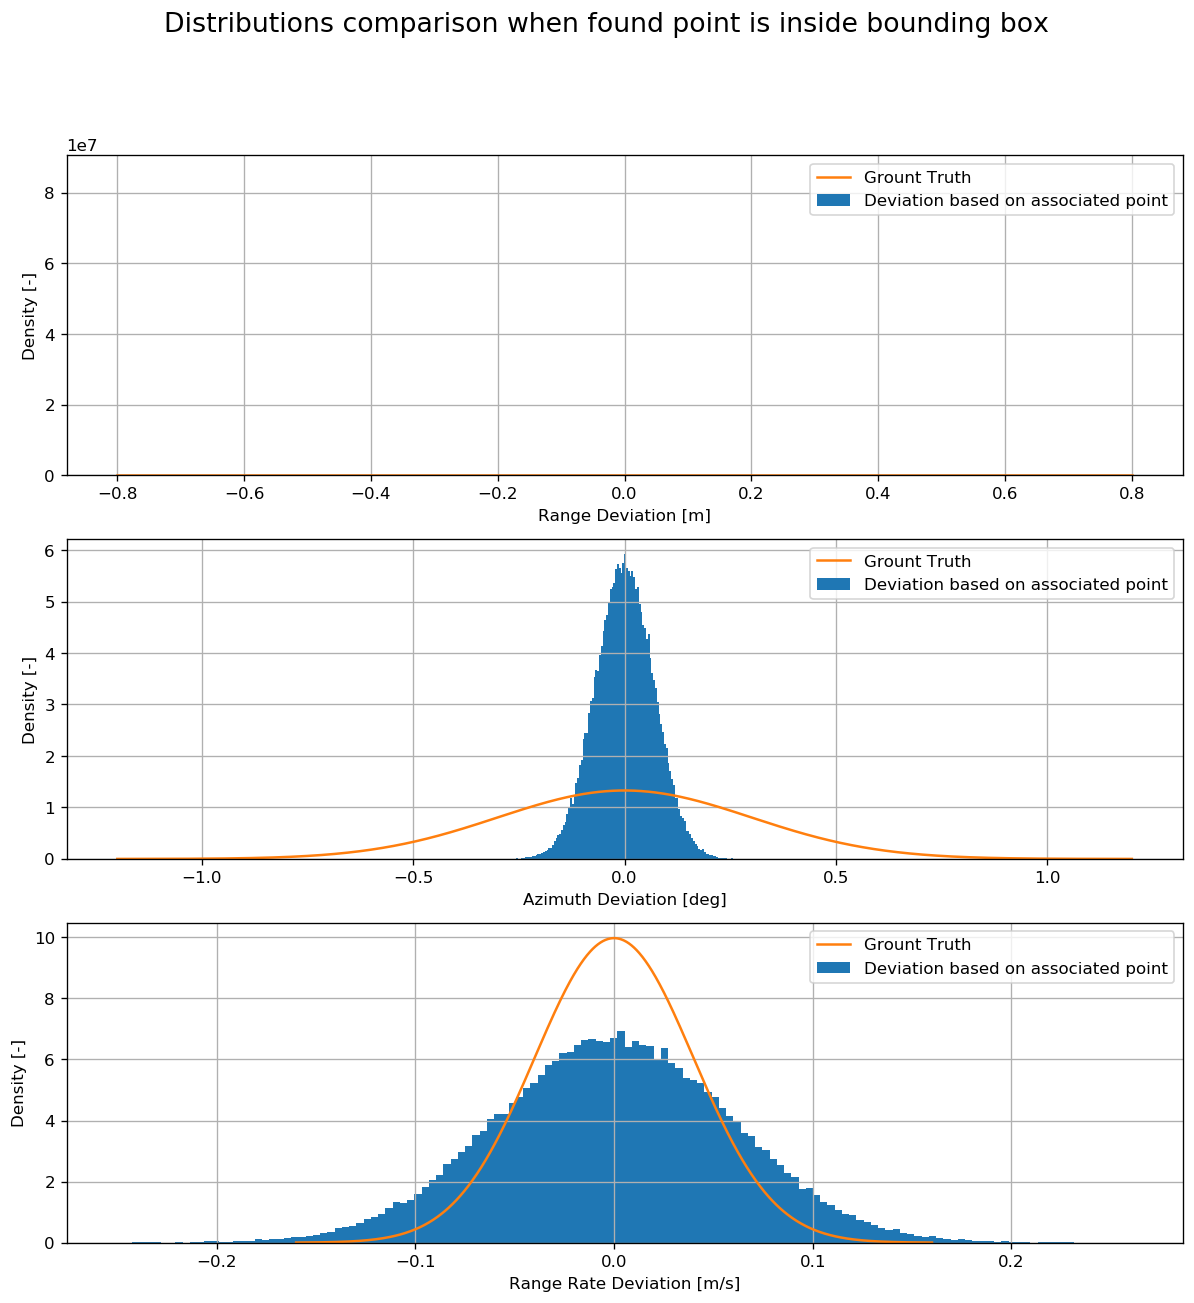

In [23]:
fig=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig.suptitle('Distributions comparison when found point is inside bounding box', fontsize=16)
plot_det_distributions(sim_out_inside, DefaultRadar)